# Old Babylonian Lists of Trees and Wooden Objects

## Introduction to research questions and analysis plan

We are interested in understanding relationships among extant versions of lexical texts. Patterns in similarity of these texts may provide important information about text provenance and/or routes of influence from one geographical area onto another. 

We are also interested in understanding the patterns by which lexical texts evolved and changed. 

In comparing versions of a lexical text we may think of four types of features: 

1) presence or absence of entries  
2) order of entries within a section  
3) order of sections in a document  
4) spelling of words  

The following sections will explore these four features independently and in combination to uncover patterns of similarity among documents.

## Introduction to dataset and data structure

This notebook uses data from [DCCLT](http://oracc.org/dcclt) derived from parsed JSON files. For the [ORACC](http://oracc.org) JSON output see the [ORACC Open Data documentation](http://oracc.museum.upenn.edu/doc/opendata/index.html). The JSON files are parsed with the notebook `json_corpus.iynb` in https://github.com/niekveldhuis/JSON-test. This notebook takes an input file, identifying the text IDs of the documents to be parsed. The input file is [ob_lists_wood.txt](https://github.com/ErinBecker/digital-humanities-phylogenetics/blob/master/data/text_ids/ob_lists_wood.txt). 

The input file lists all the Text IDs of Old Babylonian lists of trees and wooden objects currently in [DCCLT](http://oracc.org/dcclt), as well as the composite text of the [Nippur version](http://oracc.org/Q000039). Text IDs consist of a P plus a six-digit number (commonly referred to as P-number) that is recognized by [ORACC](http://oracc.org) and by [CDLI](http://cdli.ucla.edu) and that has become the de-facto standard in Assyriology. [CDLI](http://cdli.ucla.edu) provides metadata (provenience, period, publication, museum number, etc) for each text. Composite text IDs consist of a Q plus a six-digit number (for instance Q000039). Texts that have not (yet) been cataloged in [CDLI](http://cdli.ucla.edu) receive a (temporary) six-digit X number.

The raw data are placed in the directory [data/raw](https://github.com/ErinBecker/digital-humanities-phylogenetics/tree/master/data/raw). Each document has a separate file named dcclt_P######.txt (or dcclt_Q######.txt). These are comma-separated files with the following fields: 

| field         | description                     |
|-----------	|------------------------------------------------------------------------------------------------------------------------------------------------------	|
| id_line   	| consists of a text ID (P, Q, or X numebr) plus a reference number 	|
| label 	| line number: obverse/reverse, column number, line number (e.g. o ii 16')                                                          	|
| lemma      	| Sumerian words in lemmatized form (e.g. lugal[king]N); for unlemmatized words the raw transliteration is taken                                                                                  	|
| base      	| Sumerian words in original spelling, but without morphological prefixes or suffixes   |
| extent | (for missing data): how many lines or columns (restricted vocabulary) are missing|
| scope | (for missing data): what is missing - line, column, face, or surface (restricted vocabulary) |

There are various types of missing data, represented in different ways. A word that is present, but not lemmatized is represented in its transliterated form, followed by [NA]NA (that is: Guideword and POS are both NA). Words that are partly or entirely illegible on the original document are by definition unlemmatized and are handled the same way.

Lines or multiple lines that are missing are indicated in the fields `extent` and `scope`. `Extent` gives the number of missing lines (or missing columns, etc). The restricted vocabulary includes numbers and the words 'n' (unknown), 'beginning', and 'rest'. `Scope` indicates the scope of the missing text: line, column, obverse, etc.

| type         | how represented                     |
|-----------	|------------------------------------------------------------------------------------------------------------------------------------------------------	|
| words with unknown lemmatization| siki-siki[NA]NA |
| illegible words | x[NA]NA |
| known number of missing lines 	|extent: '5' scope: 'line' |
| unknown number of missing lines	|extent: 'n' scope: 'line |
| two missing columns  | extent: '2' scope: 'column'|
  


In [2]:
import pandas as pd
import numpy as np
import re

In [3]:
import rpy2.ipython
%load_ext rpy2.ipython

# Reading in and structuring the data
Open file `obwood.csv` and create a Dataframe in Pandas. 

In [4]:
file = '../data/ob_lists_wood.csv'
df = pd.read_csv(file).drop('Unnamed: 0', axis=1)

In [5]:
df.head()

,id_line,label,lemma,base,extent,scope
0,P117395.2,o 1,ŋešed[key]N,{ŋeš}e₃-a,NaN,NaN
1,P117395.3,o 2,pakud[~tree]N,{ŋeš}pa-kud,NaN,NaN
2,P117395.4,o 3,raba[clamp]N,{ŋeš}raba,NaN,NaN
3,P117404.2,o 1,ig[door]N eren[cedar]N,{ŋeš}ig {ŋeš}eren,NaN,NaN
4,P117404.3,o 2,ig[door]N dib[board]N,{ŋeš}ig dib,NaN,NaN


## id_text and line
The variable `id_line` contains the text ID plus a reference. The reference may be to a column, a line, or a set of broken lines. The text ID is put in the variable `id_text` and the reference is turned into an integer and put in the variable `line`. The variables `id_text` and `line` are then used to sort the dataframe.

In [6]:
df['id_text'] = df['id_line'].str[:7]
df['line'] = [int(re.sub('.+\.', '', line)) for line in df['id_line']] #create a line number for sorting
df = df.sort_values(['id_text', 'line']).reset_index(drop=True)
df.head()

,id_line,label,lemma,base,extent,scope,id_text,line
0,P117395.2,o 1,ŋešed[key]N,{ŋeš}e₃-a,NaN,NaN,P117395,2
1,P117395.3,o 2,pakud[~tree]N,{ŋeš}pa-kud,NaN,NaN,P117395,3
2,P117395.4,o 3,raba[clamp]N,{ŋeš}raba,NaN,NaN,P117395,4
3,P117404.2,o 1,ig[door]N eren[cedar]N,{ŋeš}ig {ŋeš}eren,NaN,NaN,P117404,2
4,P117404.3,o 2,ig[door]N dib[board]N,{ŋeš}ig dib,NaN,NaN,P117404,3


## The `skip` variable

The variable `skip` is used to compute the distance between two lines in the data set. If a line has data (in `label`, `lemma`, and `base`) `skip` = 0. If, however, the original text has 5 missing lines, there will be a separate row, where `skip` is 5. If there is a gap in the text of unknown length, `skip` will be NaN.

The `skip` variable works as follows (simplified data representation):

|`label` | `lemma` | `skip` | `line`
|--------|----------|--------|------|
| o ii 4 | gigir[chariot]N    | 0| 43 |
| o ii 5 | sahargi[dustguard]N gigir[chariot]N | 0| 44 |
| NaN     | NAN     | 5 | 45 |
| o ii 11 | margida[wagon]N | 0| 46 |


The distance between the `margida[wagon]N` line and the `gigir[chariot]N` line is 7 (`line`₂ - `line`₁ + `skip`₁:₂ -1).

The variable `skip` is computed from the [ORACC](http://oracc.org) variables `extent` and `scope`, which are part of the so-called \$-line conventions. These conventions are explained in more detail [here](http://oracc.org/doc/help/editinginatf/primer/structuretutorial). A 'strict' \$-line uses a limited vocabulary to describe the preservation or state of the object on which the text is written. Examples of strict \$-lines are:,
* \$ beginning of column missing
* \$ 7 lines traces

In these examples '7' and 'beginning' are the `extent`; 'column' and 'line' are `scope` ('missing' and 'traces' are `state`. The variable 'state' is ignored here - treating 'missing', 'broken', 'traces', etc. all as absence of data).

If lines are missing the `extent` variable will indicate the number of missing lines or columns. A line with data has `extent` NaN.

The variable `skip` is computed as follows:

* if the line has data (in `label`, `lemma`, and `base`) `skip` = 0
* if `scope` == 'column', or anything other than 'line', `skip` = NaN
* if `extent` is a digit, `skip` is the integer version of that digit
* if `extent` is 'n' or 'beginning' (or anything other than a digit), `skip` = NaN

Because NaN cannot be used in a column of integers, `skip` will become a float.

## Note to Erin

I am proposing here to introduce a new variable `skip` (rather than adjust the variable `extent`). I think that is clearer to outsiders (and to our future selves). I hope the explanation of how it is done is also clearer. I haven't actually done what I describe here - because it would mess with your datastructure. Essentially, everything remains exactly the same, but what was called `extent` will now be called `skip`. Note that the formula for line distance needs more thought. The number of rows that have some `skip` value needs to be subtracted - there should be some smart way of doing that.

We could, of course, use `999` instead of `NaN` for `skip` - but I prefer to use `NaN` here and to present the change to `999` as a feature of handing the data off to R.

In [7]:
df.extent = df.extent.fillna('0')
#df.skip = [int(n) if n.isdigit() else np.NaN for n in df.extent] # this line to be activated to introduce `skip`
df.extent = [int(n) if n.isdigit() else np.NaN for n in df.extent] # this line to be deleted when we introduce `skip`.

The variable `scope` may include 'line', 'column', 'obverse', etc. Only if scope is `line` the variable 'extent' is meaningful (if, say, 2 columns are missing, 'extent' is '2' but should be NaN because we do not know how many lines those 2 columns represent). If `scope` is NaN `extent` is '0' and should remain so. After this operation the column 'scope' can be dropped.

In [8]:
#df.skip = [df.skip[i] if df.scope[i] in ['line', np.NaN] else np.NaN for i in range(len(df))] # line to be activated when introducing `skip`
df.extent = [df.extent[i] if df.scope[i] in ['line', np.NaN] else np.NaN for i in range(len(df))] # line to be deleted when introducing `skip`
df = df.drop('scope', axis = 1)
# df = df.drop(['scope', extent], axis=1)
df.head()

,id_line,label,lemma,base,extent,id_text,line
0,P117395.2,o 1,ŋešed[key]N,{ŋeš}e₃-a,0.0,P117395,2
1,P117395.3,o 2,pakud[~tree]N,{ŋeš}pa-kud,0.0,P117395,3
2,P117395.4,o 3,raba[clamp]N,{ŋeš}raba,0.0,P117395,4
3,P117404.2,o 1,ig[door]N eren[cedar]N,{ŋeš}ig {ŋeš}eren,0.0,P117404,2
4,P117404.3,o 2,ig[door]N dib[board]N,{ŋeš}ig dib,0.0,P117404,3


In [9]:
df.loc[df.extent > 0].head() #sanity check
#df.loc[df.skip > 0].head()

,id_line,label,lemma,base,extent,id_text,line
36,P225065.4,NaN,NaN,NaN,1.0,P225065,4
45,P225126.4,NaN,NaN,NaN,2.0,P225126,4
88,P235262.4,NaN,NaN,NaN,10.0,P235262,4
109,P235262.30,NaN,NaN,NaN,8.0,P235262,30
110,P235262.31,NaN,NaN,NaN,4.0,P235262,31


## Create Expressions
A line in a lexical text may contain more than one word. Usually a list is divided into sections by keyword, for instance:

| text                	| translation                      	|
|---------------------	|----------------------------------	|
| {ŋeš}gigir          	| chariot                          	|
| {ŋeš}e₂ gigir       	| chariot cabin                    	|
| {ŋeš}e₂ usan₃ gigir 	| storage box for the chariot whip 	|
| {ŋeš}gaba gigir     	| breastwork of a chariot          	|

In the comparison between different versions of the list the individual words are less interesting than the *entries*, that is: the sequence of words in a single line. In order to look at entries (rather than words), words in an entry are connected by underscores (_). Since in this case all words are in Sumerian, the language designation (sux:) is removed from the field `entry`.

In [10]:
df['entry'] = df['lemma']
df['entry'] = df['entry'].str.replace(' ', '_')
df.head()

,id_line,label,lemma,base,extent,id_text,line,entry
0,P117395.2,o 1,ŋešed[key]N,{ŋeš}e₃-a,0.0,P117395,2,ŋešed[key]N
1,P117395.3,o 2,pakud[~tree]N,{ŋeš}pa-kud,0.0,P117395,3,pakud[~tree]N
2,P117395.4,o 3,raba[clamp]N,{ŋeš}raba,0.0,P117395,4,raba[clamp]N
3,P117404.2,o 1,ig[door]N eren[cedar]N,{ŋeš}ig {ŋeš}eren,0.0,P117404,2,ig[door]N_eren[cedar]N
4,P117404.3,o 2,ig[door]N dib[board]N,{ŋeš}ig dib,0.0,P117404,3,ig[door]N_dib[board]N


## Group by Document
The `groupby()` function is used to group the data by document. The function `apply(' '.join)` concatenates the text in the `entries` column, separating them with a white space. The Pandas `groupby()` function results in a series, which is then tranformed into a new Dataframe.

In [11]:
df['entry'] = df['entry'].fillna('')
entries_df = df[['id_text', 'line', 'entry']]
#entries_df = entries_df.dropna()
grouped = entries_df['entry'].groupby(entries_df['id_text']).apply(' '.join).reset_index()
by_text_df = pd.DataFrame(grouped)
by_text_df = by_text_df.set_index('id_text')
by_text_df.head()

,entry
id_text,
P117395,ŋešed[key]N pakud[~tree]N raba[clamp]N
P117404,ig[door]N_eren[cedar]N ig[door]N_dib[board]N i...
P128345,garig[comb]N_siki[hair]N garig[comb]N_siki-sik...
P224980,gigir[chariot]N e[house]N_gigir[chariot]N e[ho...
P224986,guza[chair]N_anše[equid]N guza[chair]N_kaskal[...


## Questions for Niek
1) What does the symbol "~" mean in the lemmatization? For example in row number one of the df above "~tree". 

NV: This means: "pertains to" and is used for words of vague or unclear semantics.

2) Can you explain what's going on with the "line" column? It appears to start at an arbitrary number for each document.  

NV: The field `line` is derived directly from the field `id_line`, minus the `id_text` (P-number) element. `Id_line` is a string but `line` is an integer, used to keep the lines in the right order.  

3) Why do the first several entries in the DTM start with a number? It looks like these are all words that are unlematized. What do the numbers refer to? Is "10[na]_na" different from "11[na]_na"?

NV: Some of these entries come from P251686 - and they indicate a problem we hadn't seen before. This is a tablet that combines a list of wooden objects with a metrological table. The metrological table shouldn't be here - there are, I believe, a few other such instances.

# Part 1: Analysis based on order of entries within a section

## Defining sections

The first step in analyzing order of entries within a section must be defining what constitutes a section. We've discussed three methods for defining sections. 

**1) Expert definition.**  
**2) Automated based on composite text (eg. Q000039).**  
**3) Automated based on entry proximity.** 

These methods are described more below:


**1) Expert definition.**  
Expert manually determines section boundaries based on knowledge of text type. This approach is the most sound, but does not scale. We would not be able to use our workflow with other collections of lexical lists unless without a time-intensive manual step. This method will be set aside for now. We may, however, want to leave users (assuming there ever are any) the option to read in and use their own section definitions for downstream analyses.  

**2) Automated based on composite text.**  
A composite text is read in and breakpoints in the text are determined based on fuzzy matching of similar words (either in base or lemma). Entries between those breakpoints are assumed to belong to the same section. This method would need to be tested and perhaps supervised to ensure that nonsense sections (a collection of words that don't really belong to any section) aren't grouped together. It may also miss sections that are based not on similarity of words (e.g. "palm") but similarity of object type or use (e.g. "bowl", "spoon", "cup"), unless that section is between two sections that are picked up by this method.  

Based on the following (artificial) Q text, this method should lead to three sections. Lines 1-4 (related to palm), lines 5-8 (related to polar), and lines 9-14 (related to tree). 

*1) ŋešnimbar[palm]N*  
*2) ŋešnimbar[palm]N sux:suhuš[offshoot]N*  
*3) deg[collect]V/t sux:ŋešnimbar[palm]N*  
*4) niŋkiluh[broom]N sux:ŋešnimbar[palm]N*  
*5) asal[poplar]N*  
*6) asal[poplar]N sux:kur[mountain]N*  
*7) asal[poplar]N sux:dug[good]V/i*  
*8) numun[seed]N sux:asal[poplar]N*  
*9) ilur[tree]N*  
*10) ad[bush]N*  
*11) kišig[acacia]N*  
*12) kišighar[tree]N*  
*13) samazum[tree]N*  
*14) peškal[tree]N*  

**3) Automated based on entry proximity**  
Lines that always apear within a certain (small) distance from each other could be considered to be part of the same section. Sections are defined based on entire corpus, not just a composite text. (eg. moving window, ~6-8 lines, middle in target)

## Method 2) Automated based on composite text.

In [12]:
# In order to pass unknown values (NaN) from Python to R, need to convert
# NaNs in character/string columns become 'unknown'
# NaNs in numeric columns become 999
# Convert both to NA after passing to R

df.extent = df.extent.fillna(999)
#df.skip = df.skip.fillna(999)
df = df.fillna('unknown')

#df.count()
df.extent.unique()
#df.skip.unique()

array([   0.,    1.,    2.,   10.,  999.,    8.,    4.,    3.,   15.,
          9.,    7.,   20.,    5.,   17.,    6.,   31.,   11.])

In [13]:
%%R -i df
# bring df into R

# convert lemma, base and entry columns to strings
df$lemma = as.character(df$lemma)
df$base = as.character(df$base)
df$entry = as.character(df$entry)
str(df)

'data.frame':	5115 obs. of  8 variables:
 $ id_line: Factor w/ 5115 levels "P117395.2","P117395.3",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ label  : Factor w/ 3006 levels "1","1'","10",..: 1777 1799 1804 1777 1799 1804 1777 1799 1804 1818 ...
 $ lemma  : chr  "ŋešed[key]N" "pakud[~tree]N" "raba[clamp]N" "ig[door]N eren[cedar]N" ...
 $ base   : chr  "{ŋeš}e₃-a" "{ŋeš}pa-kud" "{ŋeš}raba" "{ŋeš}ig {ŋeš}eren" ...
 $ extent : num  0 0 0 0 0 0 0 0 0 0 ...
 $ id_text: Factor w/ 106 levels "P117395","P117404",..: 1 1 1 2 2 2 3 3 3 4 ...
 $ line   : int  2 3 4 2 3 4 2 3 4 4 ...
 $ entry  : chr  "ŋešed[key]N" "pakud[~tree]N" "raba[clamp]N" "ig[door]N_eren[cedar]N" ...


In [14]:
%%R
# Extract only lines from composite document (in our case Q000039). 

df_composite = df[which(df$id_text == "Q000039"),]
df_composite$id_text = droplevels(df_composite)$id_text
str(df_composite)
table(df_composite$extent)
write.csv(df_composite, "Qtext.csv")

'data.frame':	778 obs. of  8 variables:
 $ id_line: Factor w/ 5115 levels "P117395.2","P117395.3",..: 4338 4449 4560 4671 4782 4893 5004 5094 5105 4339 ...
 $ label  : Factor w/ 3006 levels "1","1'","10",..: 1 126 246 368 487 617 732 733 734 756 ...
 $ lemma  : chr  "taškarin[boxwood]N" "esi[tree]N" "ŋešnu[tree]N" "halub[tree]N" ...
 $ base   : chr  "{ŋeš}taškarin" "{ŋeš}esi" "ŋeš-nu₁₁" "{ŋeš}ha-lu-ub₂" ...
 $ extent : num  0 0 0 0 0 0 0 0 0 0 ...
 $ id_text: Factor w/ 1 level "Q000039": 1 1 1 1 1 1 1 1 1 1 ...
 $ line   : int  1 2 3 4 5 6 7 8 9 10 ...
 $ entry  : chr  "taškarin[boxwood]N" "esi[tree]N" "ŋešnu[tree]N" "halub[tree]N" ...


# Sanity check - how many lines in Q000039?
Note - since R integration still doesn't work for me, this section reloads the Q000039.csv. These lines are temporary.

In [15]:
file = 'Qtext.csv'
import pandas as pd
with open(file, 'r') as f:
    df = pd.read_csv(f)
no_a_lines = df[df.label.str.isdigit()]
a_lines = df[~df.label.str.isdigit()]
len(df), len(no_a_lines), len(a_lines)

(778, 703, 75)

In [ ]:
#if(document1 == document2) {
#dist = pos2 - pos1 + sum(missing1:missing2)}
#else(invalid query)

# Part 2: Analysis based on presence/absence of entries

## Document Term Matrix
Transform the DataFrame into a Document Term Matrix (DTM) by using CountVectorizer. This function uses a Regular Expression (token_pattern) to indicate how to find the beginning and end of token. In the current Dataframe entries are separated from each other by a white space. The expression `r.[^ ]+` means: any combination of characters, except the space.

The output of the CountVectorizer (`dtm`) is not in a human-readable format. It is transformed into another DataFrame, with `id_text` as index.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(analyzer='word', token_pattern=r'[^ ]+')
dtm = cv.fit_transform(by_text_df['entry'])
dtm_df = pd.DataFrame(dtm.toarray(), columns = cv.get_feature_names(), index = by_text_df.index.values)
dtm_df.head()

,1(ban₂)[na]na_1(diš)[na]na_sila[unit]n_11[na]na,1(ban₂)[na]na_2(diš)[na]na_sila[unit]n_12[na]na,1(ban₂)[na]na_3(diš)[na]na_sila[unit]n_13[na]na,1(ban₂)[na]na_4(diš)[na]na_sila[unit]n_14[na]na,1(ban₂)[na]na_5(diš)[na]na_sila[unit]n_15[na]na,1(ban₂)[na]na_še[barley]n_10[na]na,10[na]na_še[barley]n_kugbabbar[silver]n,11[na]na_še[barley]n_kugbabbar[silver]n,12[na]na_še[barley]n_kugbabbar[silver]n,13[na]na_še[barley]n_kugbabbar[silver]n,...,šuʾa[stool]n_ašgab[leatherworker]n,šuʾa[stool]n_burgul[stone-cutter]n,šuʾa[stool]n_dus[bathroom]n,šuʾa[stool]n_kaskal[way]n,šuʾa[stool]n_nagar[carpenter]n,šuʾa[stool]n_niŋgula[greatness]n,šuʾa[stool]n_suhsah[sound]n,šuʾa[stool]n_tibira[sculptor]n,šuʾa[stool]n_x[na]na,šuʾura[goose]n
P117395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P117404,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P128345,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P224980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P224986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Analyzing the DTM
Each document in the DTM may be understood as a vector, which allows for various kinds of computations, such as distance or cosine-similarity. 

It is important to recall that the DTM does not preserve information about the order of entries.

It is also important to realize that the documents in this analysis of are of very different length (from 1 to 750 entries), with more than half of the documents 3 lines or less. The composite text from Nippur is by far the longest document and will dominate any comparison

In [17]:
df_length = dtm_df.sum(axis=1)
df_length.describe()

count    106.000000
mean      46.254717
std      128.342923
min        1.000000
25%        3.000000
50%        3.000000
75%       16.250000
max      776.000000
dtype: float64

Note that I'll be doing some analysis in R, whereas Niek will be doing some in Python. We can use both languages in different cells of the same notebook and even pass variables between languages. See tip #21 [here](https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/).

FYI - if you have difficulty running R cells in a Python notebook using rpy2, try installing
rpy2 through conda instead of through pip.  

`conda install -c r rpy2`

## Make sure the R correctly parsed the DTM  
- It looks like R doesn't allow variable names to start with a number, thus all entries starting with a number had "X" added to the beggining of the entry name.  
- R doesn't allow parentheses in variable names, so entries like "1(ban₂)[na]na" parsed as "X1.ban...na.na".   
- 



In [18]:
%%R -i dtm_df
#Import dtm_df from Python

# Set cols and rows to sum to not include summary column and row added later
# This needs to be in separate cell from addition of summary col and row!
cols_to_sum = ncol(dtm_df)
rows_to_sum = nrow(dtm_df)

#head(dtm_df[,1:10])
#str(dtm_df)

## Check density of DTM

Look at distribution of document lengths (number of entries per document).  
Look at distribution of entry freqency (number of documents each entry appears in).

[1] "There are 34 documents with 10 or more entries."
[1] "There are 14 documents with 100 or more entries."


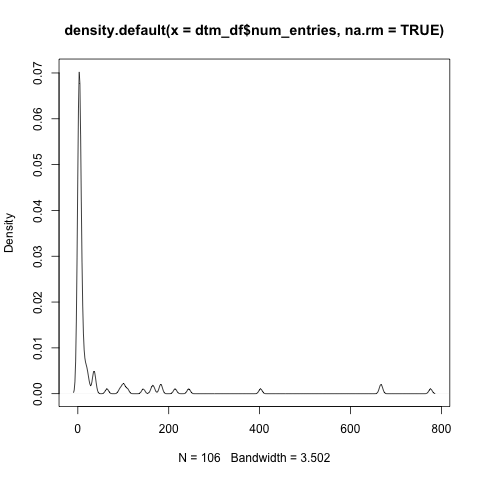

In [19]:
%%R

dtm_df$num_entries = rowSums(dtm_df[1:cols_to_sum])
dtm_df["num_occurances",] = colSums(dtm_df[1:rows_to_sum,])
dtm_df["num_occurances","num_entries"] = NA 

plot(density(dtm_df$num_entries, na.rm = TRUE))
table(dtm_df$num_entries, useNA = "ifany") #number of documents with each number of entries

print(paste("There are", length(which(dtm_df$num_entries >= 10)), "documents with 10 or more entries."))
print(paste("There are", length(which(dtm_df$num_entries >= 100)), "documents with 100 or more entries."))

[1] "76.88% of entries appear only once or twice across the corpus"
[1] "25 entries occur in 10 or more documents"
[1] "including one that occurs 189 times across the 106 documents"
[1] "The most common entry is X.ŋeš.x.na.na"


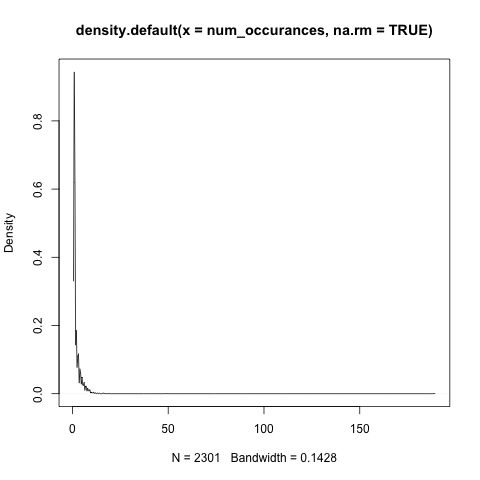

In [20]:
%%R 

num_occurances = unlist(dtm_df["num_occurances",])
plot(density(num_occurances, na.rm = TRUE))
table(num_occurances, useNA = "ifany")

rare = round(length(which(dtm_df["num_occurances",] <=2))/cols_to_sum*100,2)
common = length(which(dtm_df["num_occurances",] >=10))
most_common = max(dtm_df["num_occurances",], na.rm = TRUE)
most_common_entry = colnames(dtm_df[which(dtm_df["num_occurances",] == most_common)])

print(paste0(rare, "% of entries appear only once or twice across the corpus"))
print(paste(common, "entries occur in 10 or more documents"))
print(paste("including one that occurs", most_common, "times across the", rows_to_sum, "documents"))
print(paste("The most common entry is", most_common_entry))

In [21]:
%%R 
# Look at some of the most common entries
colnames(dtm_df)[which(dtm_df["num_occurances",] >= 10)]

 [1] "al.hoe.n"                      "allanum.oak.n"                
 [3] "dilim.spoon.n"                 "e.house.n_gigir.chariot.n"    
 [5] "ellag.ball.n"                  "gigir.chariot.n"              
 [7] "guza.chair.n_x.na.na"          "hašhur.apple.n"               
 [9] "hašhur.apple.n_kur.mountain.n" "kid.da.twig.n"                
[11] "kur.wood.n"                    "madal.pole.n"                 
[13] "peš.fig.n"                     "sugin.rot.n"                  
[15] "x.x.na.na"                     "x.na.na"                      
[17] "x.na.na_ŋešnimbar.palm.n"      "X.ŋeš.kal.na.na"              
[19] "X.ŋeš.x.x.x.na.na"             "X.ŋeš.x.x.na.na"              
[21] "X.ŋeš.x.na.na"                 "X.ŋeš.x.na.na_apin.plow.n"    
[23] "šagkal.tree.n"                 "šedug.tree.n"                 
[25] "šenu.tree.n"                  


In [22]:
%%R 

# currently "variables" (entries) are sorted alphabetically, would like sorted by frequency
dtm_df = as.matrix((dtm_df > 0) + 0) # Converts to binary presence/absence information
dtm_df = dtm_df[,order(colSums(dtm_df), decreasing = TRUE)]
dtm_df = as.data.frame(dtm_df)

In [23]:
%%R 

# Need to recaculate number of occurances, as was converted to binary. 
dtm_df$num_entries = rowSums(dtm_df[1:cols_to_sum])
dtm_df["num_occurances",] = colSums(dtm_df[1:rows_to_sum,])
dtm_df["num_occurances","num_entries"] = NA 

num_occurances = unlist(dtm_df["num_occurances",])
most_frequent = max(num_occurances, na.rm = TRUE)
most_frequent_entry = colnames(dtm_df[which(dtm_df["num_occurances",] == most_frequent)])

print(paste(table(num_occurances)[1], "entries appear in only one document"))
print(paste("The entry that appears in the most documents is", most_frequent_entry))

table(num_occurances, useNA = "ifany")


[1] "1547 entries appear in only one document"
[1] "The entry that appears in the most documents is X.ŋeš.x.na.na"
num_occurances
   1    2    3    4    5    6    7    8    9   10   11   12   21 <NA> 
1547  270  169  118   69   56   26   25    8    7    4    1    1    1 


In [24]:
%%R
# These entries appear in at least 10 different documents.
colnames(dtm_df)[which(dtm_df["num_occurances",] >=10)]

 [1] "X.ŋeš.x.na.na"                 "al.hoe.n"                     
 [3] "hašhur.apple.n"                "hašhur.apple.n_kur.mountain.n"
 [5] "peš.fig.n"                     "šedug.tree.n"                 
 [7] "allanum.oak.n"                 "dilim.spoon.n"                
 [9] "e.house.n_gigir.chariot.n"     "gigir.chariot.n"              
[11] "X.ŋeš.x.x.na.na"               "šagkal.tree.n"                
[13] "šenu.tree.n"                  


In [25]:
%%R
dtm_df$document = row.names(dtm_df) #add document names as row names
dtm_df = dtm_df[-which(row.names(dtm_df) == "num_occurances"),] # remove num_occurances row

In [26]:
%%R

#install.packages("reshape")
library(reshape)

melted_dtm_df = melt(dtm_df)
head(melted_dtm_df)

//anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Using document as id variables

  warnings.warn(x, RRuntimeWarning)


  document      variable value
1  P117395 X.ŋeš.x.na.na     0
2  P117404 X.ŋeš.x.na.na     0
3  P128345 X.ŋeš.x.na.na     0
4  P224980 X.ŋeš.x.na.na     0
5  P224986 X.ŋeš.x.na.na     0
6  P224994 X.ŋeš.x.na.na     0


In [27]:
%%R 
# http://stackoverflow.com/questions/10397183/heat-map-of-binary-data-using-r-or-python
#install.packages("ggplot2")
library(ggplot2)
# ggplot(data = melted_dtm_df[150000:160474,], aes(y=document, x=variable, fill=value)) + 
#   geom_tile() +
#   theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 5))

#qplot(data=melted_dtm_df, x=variable,y=document, fill=factor(value),
#    geom="tile")+scale_fill_manual(values=c("0"="lightblue", "1"="red")) +
#  theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 1), axis.text.y = element_text(size = 3))

# Look at a subset
# qplot(data = melted_dtm_df[1:10000,], x=variable, y=document, fill=factor(value),
#     geom="tile")+scale_fill_manual(values=c("0"="lightblue", "1"="red")) +
# theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 8), axis.text.y = element_text(size = 5))



Error: package or namespace load failed for ‘ggplot2’


//anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error : object ‘f_eval’ is not exported by 'namespace:lazyeval'

  warnings.warn(x, RRuntimeWarning)
//anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
//anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
//anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 1: package ‘reshape’ was built under R version 3.2.5 

  warnings.warn(x, RRuntimeWarning)
//anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 2: package ‘ggplot2’ was built under R version 3.2.5 

  warnings.warn(x, RRuntimeWarning)
//anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error: package or namespace load failed for ‘ggplot2’

  warnings.warn(x, RRun

## Grouping Documents by Entry Similarity  
We can use hierarchical clustering with our presence/absence matrix to uncover groups of similar documents. Ideally, we can benchmark these clusters' accuracy in uncovering geographically or chronologically related documents by looking at metadata, but for this collection the metadata may be too sparse to do that benchmarking.  

In either case, we can establish a workflow for doing hierarchical clustering and apply that to other datasets with better provenance information to test for cluster utility.  

Troubleshooting note:  
When running R as a magic within Jupyter notebook, running install.packages() leads to the notebook prompting you for a selection. It turns out that this is due to the fact that anaconda actually installs a second R installation and stores installed packages separately from the users "main" R installation.  

To avoid this issue, run '.libPaths()' within R in your console to find the path where anaconda stores your packages. You can then download binaries from CRAN and put them in that directory. 

In [ ]:
# %%R 
# See Troubleshooting note above

#install.packages("ggdendro")
# install.packages("ggdendro", "/anaconda/lib/R/library")

In [ ]:
%%R
library(ggdendro)
clusters <- hclust(dist(dtm_df))

In [ ]:
%%R
ggdendrogram(clusters, rotate = TRUE) + theme(axis.text.y = element_text(size = 8))

## Adding provenience by using ORACC metadata
The file `data/metadata/dcclt-eta.csv` contains some metadata, including document provenience when known. We read in this data and add provenience to our DTM.

In [ ]:
%%R 
# Bring in metadata
ids = read.csv("../data/metadata/dcclt_meta.csv")
ids$document = ids$X
ids$X = NULL
head(ids)

In [ ]:
%%R
# Add provenance information to dtm_df
dtm_df = merge(dtm_df, ids, by = "document")
dtm_df$provenience = droplevels(dtm_df)$provenience
table(dtm_df$provenience)

In [ ]:
%%R

# Add colors to dendrogram by provenance
library(scales)
numColors = length(levels(factor(dtm_df$provenience)))
numColors
myPalette = brewer_pal(palette = "Paired")(numColors)
names(myPalette) = levels(dtm_df$provenience)
print(names(myPalette))
show_col(myPalette)
ggdendrogram(clusters, rotate = TRUE) + 
theme(axis.text.y = element_text(size = 8, color = myPalette[dtm_df$provenience]))